### Description
Author: T. Majidzadeh

Date Created: March 26, 2025

Date Updated: March 28, 2025

Purpose: Tune ARIMA parameters for forecasting Zillow Observed Rent Index (ZORI) values in a but-for world absent COVID from 2020 onwards.

#### Setup

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error as rmse
import altair as alt
import datetime
import json
import os
import re
import warnings
warnings.filterwarnings(action='once')

In [4]:
paths = {
    "zillow_raw": "..\\data\\zillow_data_raw\\",
    "zillow_reg": "..\\data\\zillow_reg_data\\"
}

In [5]:
zillow_reg = pd.read_pickle(paths['zillow_reg']+'zillow_data_reg_proto_20250309.pkl')

In [6]:
def get_time_series(city, df, start_date, end_date):
    '''
    Given a city name, panel data, start date and end date, extract a time series for the ARIMA model.
    Inputs:
        city: A city name, in string format.
        df: A panel dataset which includes at least ZORI values by city and month, 
            in Pandas DataFrame format.
        start_date, end_date: The start and end dates of the time series, in either string
            or datetime.date format (function checks), expressed %Y-%m-%d, inclusive.
    Exports:
        time_series_out: A time series for City from Start Date to End Date.
    '''
    if not isinstance(start_date, datetime.date):
        start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    if not isinstance(end_date, datetime.date):
        end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()

    time_series_out = df[
        (df['RegionName'] == city) & 
        (df['Year-Month'] >= start_date) & 
        (df['Year-Month'] <= end_date)]['ZORI']
    return time_series_out


def lag_term(df, num_months=1):
    sorted_df = df.sort_values(by=['RegionName', 'Year-Month'])
    shifted = sorted_df.groupby('RegionName')['ZORI'].shift(num_months)
    return shifted

def train_and_test_arima(
    arima_params, 
    city, 
    df, 
    train_start_date, 
    train_end_date, 
    test_start_date, 
    test_end_date, 
    score_func
    ):
    '''
    Given a set of ARIMA parameters and a dataframe, create an ARIMA model and score it.
    Inputs:
        arima_params: ARIMA parameters, tuple format ((p, d, q), (P, D, Q, S)).
        city: Which city to fit the model, string format.
        df: A DataFrame with the ZORI values for each city over time.
        train_start_date, train_end_date: Start and end date for training data.
        test_start_date, test_end_date: Start and end date for test data.
            Coerce dates to datetime.date format if they are strings.
        score_func: Function to score.
    Outputs: 
        score: The output of the score_func when comparing predicted values to test data.
    '''
    assert isinstance(arima_params, tuple), "Model params should be a tuple."
    assert isinstance(arima_params[0], tuple), "ARIMA params should be a tuple (p, d, q)"
    assert isinstance(arima_params[1], tuple), "SARIMA params should be a tuple (P, D, Q, S)"
    assert (len(arima_params[0]) == 3) & (len(arima_params[1]) == 4), "Model should be a tuple ((p, d, q), (P, D, Q, S))"
    assert isinstance(city, str), "City should be a string"
    if not isinstance(train_start_date, datetime.date):
        train_start_date = datetime.datetime.strptime(train_start_date, '%Y-%m-%d').date()
    if not isinstance(train_end_date, datetime.date):
        train_end_date = datetime.datetime.strptime(train_end_date, '%Y-%m-%d').date()
    if not isinstance(test_start_date, datetime.date):
        test_start_date = datetime.datetime.strptime(test_start_date, '%Y-%m-%d').date()
    if not isinstance(test_end_date, datetime.date):
        test_end_date = datetime.datetime.strptime(test_end_date, '%Y-%m-%d').date()

    train_series, test_series = get_time_series(
            city, df, train_start_date, train_end_date
        ), get_time_series(city, df, test_start_date, test_end_date)
    
    arima_model = ARIMA(
        train_series, 
        order=arima_params[0], 
        seasonal_order=arima_params[1],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    arima_model_fit = arima_model.fit()
    forecast = arima_model_fit.forecast(steps=len(test_series))
    score = score_func(forecast, test_series)
    return score

In [7]:
zillow_reg['ZORI-Lag2'] = lag_term(zillow_reg, num_months=2)
zillow_reg['ZORI-Lag3'] = lag_term(zillow_reg, num_months=3)

#### Check Autocorrelation (Parameter p)

In [9]:
# Autocorrelation is very high up to AR values of 3.
# AR values above 3 are rarely necessary - see, e.g., https://stats.stackexchange.com/questions/285093/why-does-default-auto-arima-stop-at-5-2-5.
alt.Chart(zillow_reg[['ZORI-Lag3', 'ZORI', 'RegionName']]).mark_point().encode(
    x='ZORI:Q',
    y='ZORI-Lag3:Q',
    color='RegionName'
)

C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\schemapi.py:353: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(root or schema)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in f

alt.Chart(...)

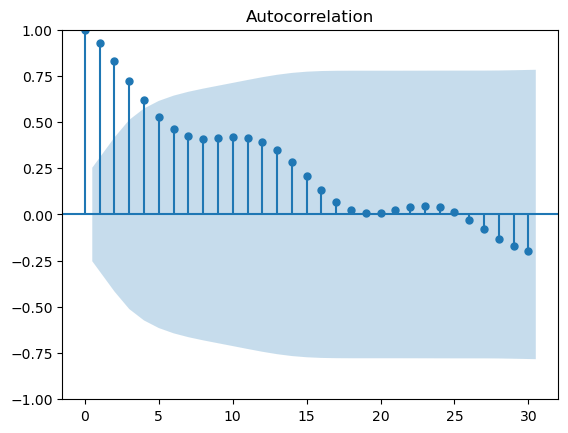

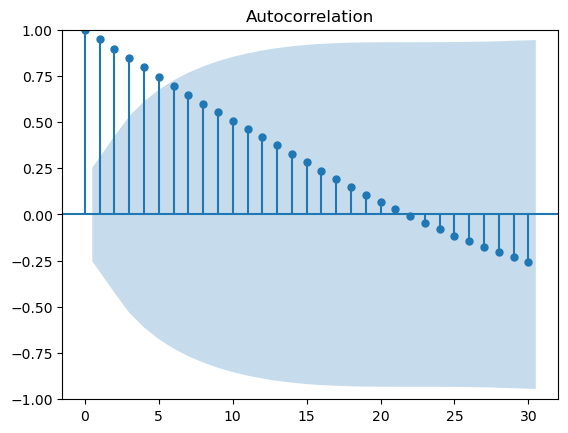

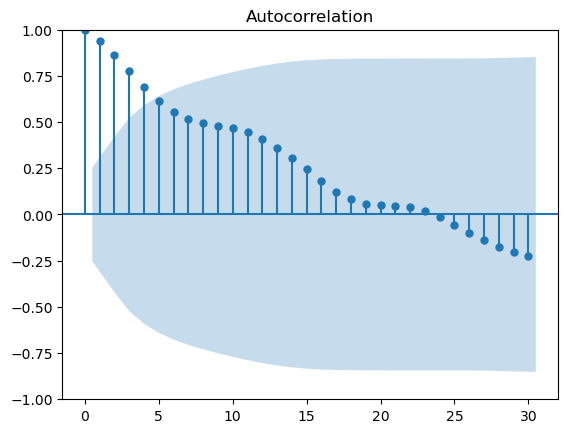

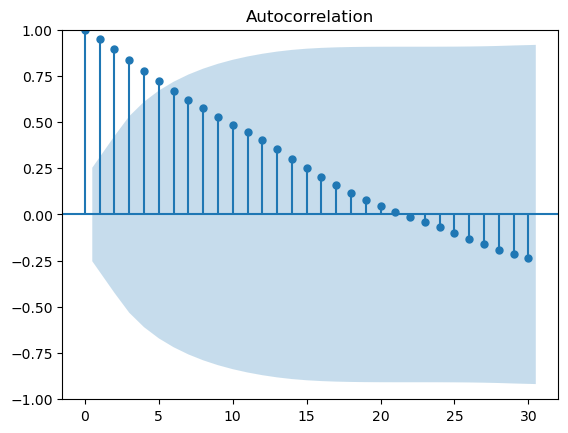

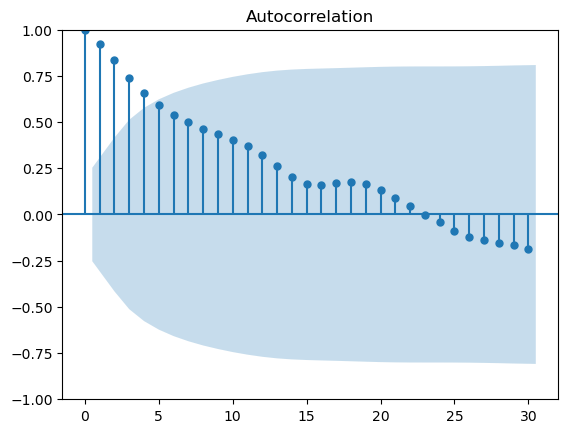

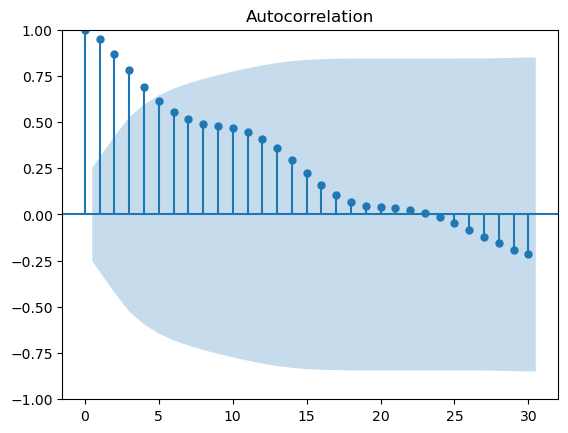

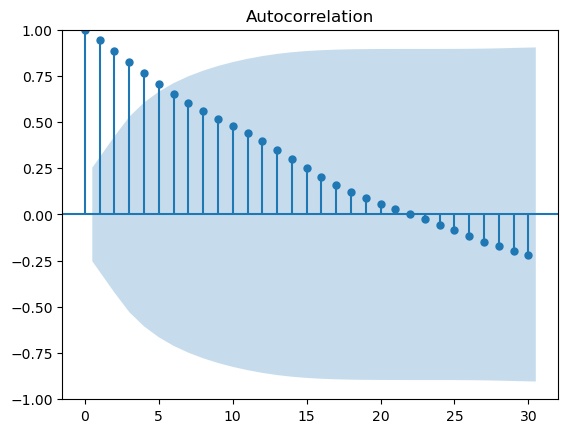

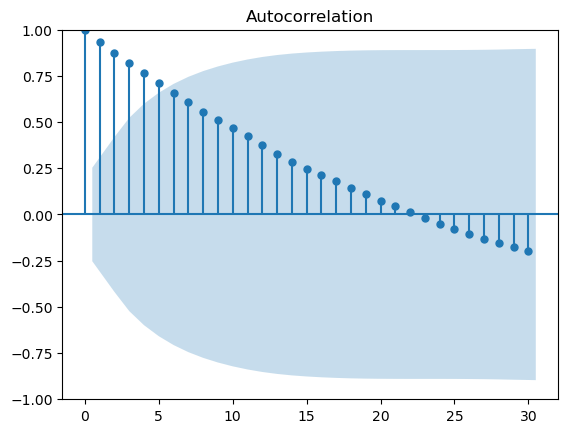

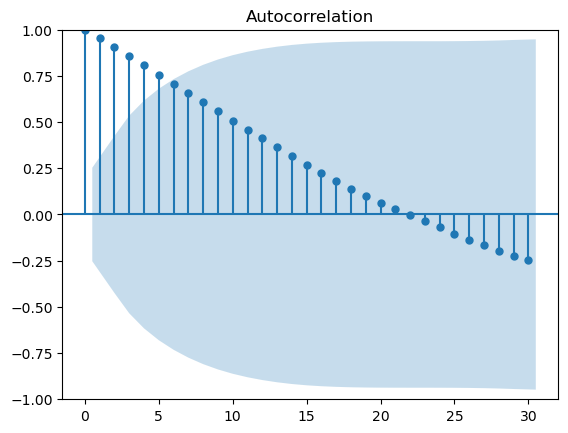

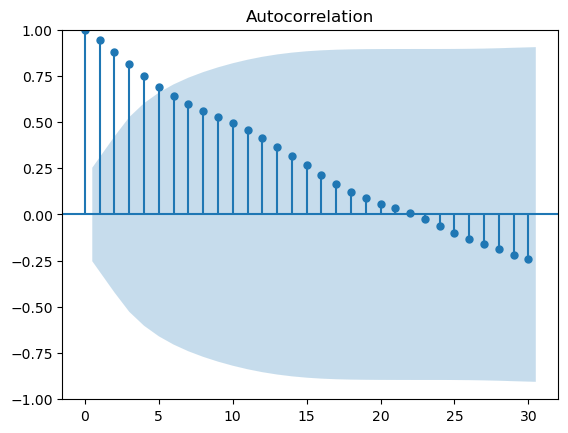

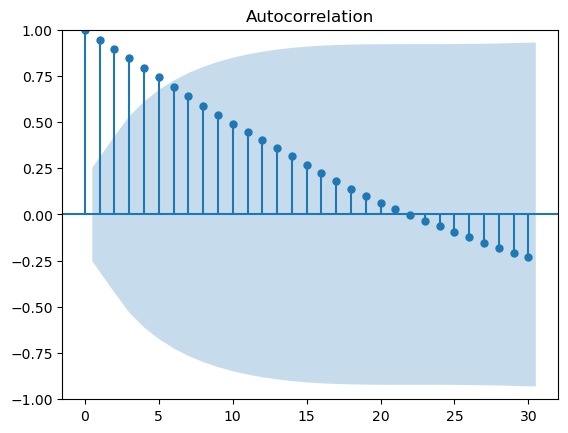

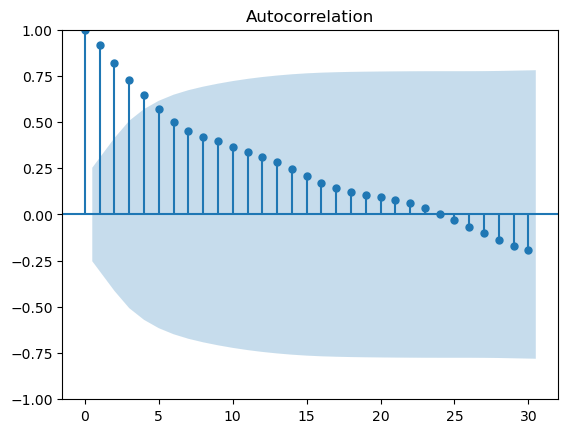

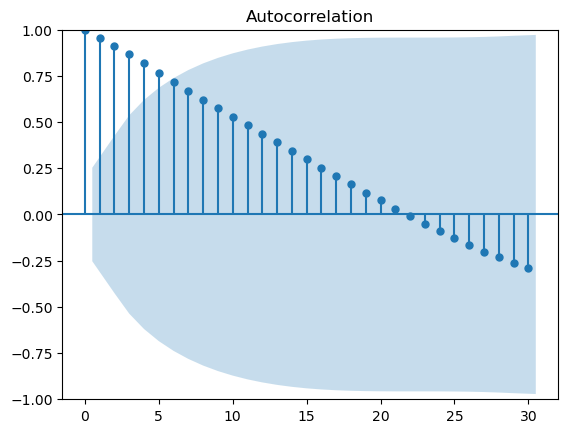

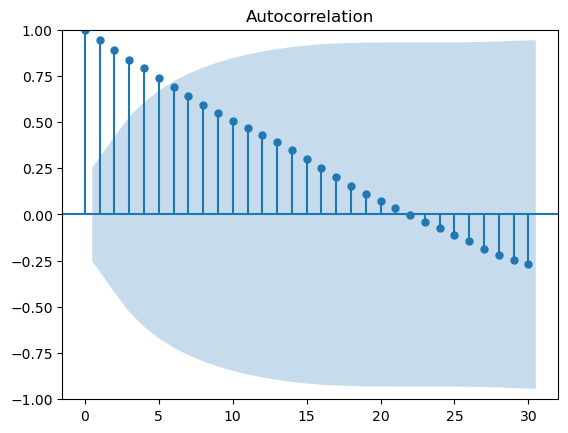

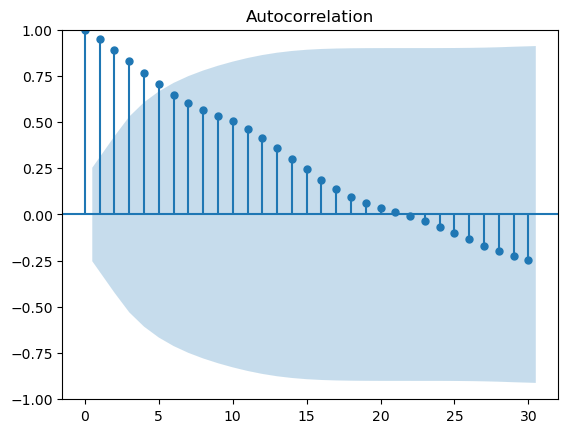

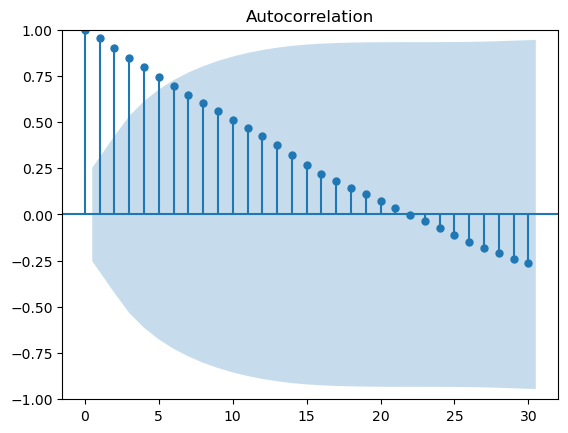

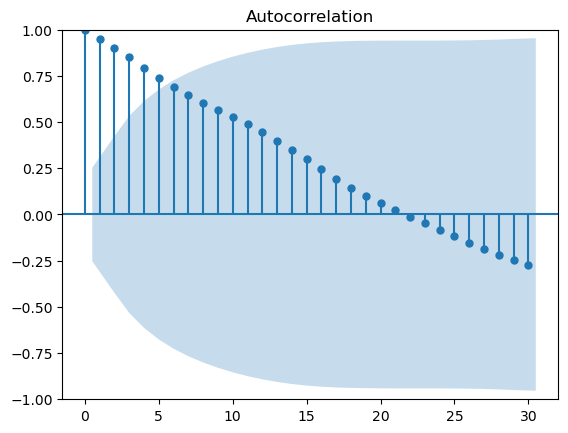

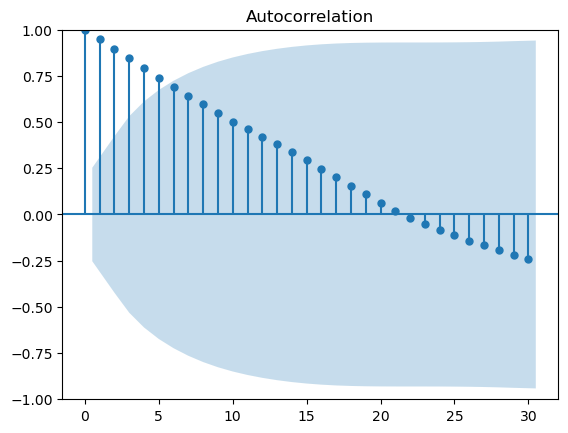

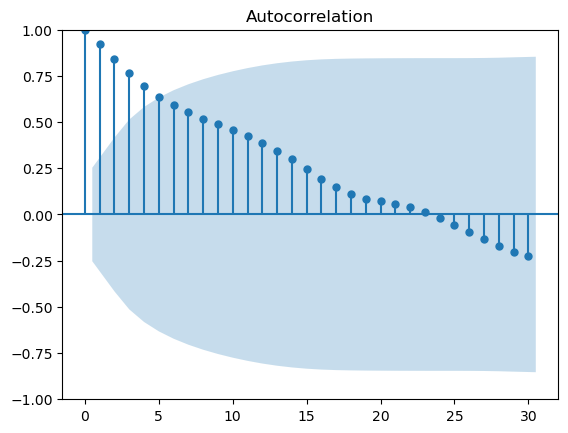

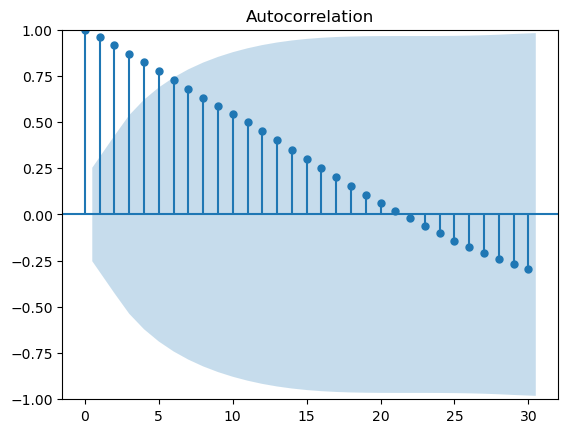

In [10]:
# Significant at at least 5 terms for all cities.
# Minor sinusoidal movement evidence of a seasonal component for some cities.
# Gradual decline evidence of non-stationarity for all cities.
for city in zillow_reg['RegionName'].unique():
    time_series = get_time_series(city, zillow_reg, '2015-01-31', '2019-12-31')
    plot_acf(time_series, lags=len(time_series)/2)

#### Check Differencing (parameter d)

In [12]:
# Only three cities show evidence of stationarity for pre-merger period.
# All others appear non-stationary.
for city in zillow_reg['RegionName'].unique():
    time_series = get_time_series(city, zillow_reg, '2015-01-31', '2017-11-30')
    test = adfuller(time_series)
    print(f"{city} pval: {test[1]}")
    if test[1] < 0.05:
        print(f"{city} pval significant at .05 level")

New York, NY pval: 0.0015139525989073626
New York, NY pval significant at .05 level
Los Angeles, CA pval: 0.908976296119576
Chicago, IL pval: 0.024321393675038973
Chicago, IL pval significant at .05 level
Dallas, TX pval: 0.8375357427325714
Houston, TX pval: 0.22893888316802985
Washington, DC pval: 0.9531794794729722
Philadelphia, PA pval: 0.8551957626659781
Miami, FL pval: 0.13443430762575437
Atlanta, GA pval: 0.518155679612509
Boston, MA pval: 0.8799470845254826
Phoenix, AZ pval: 0.8059309408387457
San Francisco, CA pval: 0.0002576070860217048
San Francisco, CA pval significant at .05 level
Riverside, CA pval: 0.9778463751272879
Detroit, MI pval: 0.9811338776732887
Seattle, WA pval: 0.9333485278750306
Minneapolis, MN pval: 0.9801131762876181
San Diego, CA pval: 0.9865391798600924
Tampa, FL pval: 0.5246947957021895
Denver, CO pval: 0.11264347260913127
Las Vegas, NV pval: 1.0


In [13]:
# Only four cities show evidence of stationarity for post-merger period.
# All others appear non-stationary.
for city in zillow_reg['RegionName'].unique():
    time_series = get_time_series(city, zillow_reg, '2017-12-01', '2019-12-31')
    test = adfuller(time_series)
    print(f"{city} pval: {test[1]}")
    if test[1] < 0.05:
        print(f"{city} pval significant at .05 level")

New York, NY pval: 0.9989319414987633
Los Angeles, CA pval: 0.4597716818273615
Chicago, IL pval: 0.5203925604452438
Dallas, TX pval: 0.9235628475613329
Houston, TX pval: 0.46808538445061126
Washington, DC pval: 0.4889256894504233
Philadelphia, PA pval: 0.9965032467063818
Miami, FL pval: 0.8516633217407898
Atlanta, GA pval: 3.565784582687739e-19
Atlanta, GA pval significant at .05 level
Boston, MA pval: 0.9936624607143342
Phoenix, AZ pval: 0.9807763192436159
San Francisco, CA pval: 0.02822431365683195
San Francisco, CA pval significant at .05 level
Riverside, CA pval: 2.7769700801009435e-05
Riverside, CA pval significant at .05 level
Detroit, MI pval: 0.9974689242571861
Seattle, WA pval: 0.992961925785336
Minneapolis, MN pval: 0.9860690034203786
San Diego, CA pval: 0.2031843504794416
Tampa, FL pval: 0.763140773617349
Denver, CO pval: 0.5017284633350049
Las Vegas, NV pval: 3.030773379737484e-05
Las Vegas, NV pval significant at .05 level


In [14]:
# There is evidence of non-stationarity for all of the series for full pre-covid period,
# including the cities with some evidence of stationarity in the smaller periods.
for city in zillow_reg['RegionName'].unique():
    time_series = get_time_series(city, zillow_reg, '2015-01-31', '2019-12-31')
    test = adfuller(time_series)
    print(f"{city} pval: {test[1]}")
    if test[1] < 0.05:
        print(f"{city} pval significant at .05 level")

New York, NY pval: 0.9988607690711411
Los Angeles, CA pval: 0.08800844765322657
Chicago, IL pval: 0.6642985927750311
Dallas, TX pval: 0.3340391056491465
Houston, TX pval: 0.44863498727442636
Washington, DC pval: 0.9864567492122234
Philadelphia, PA pval: 1.0
Miami, FL pval: 0.9785526554283002
Atlanta, GA pval: 0.4660290648747866
Boston, MA pval: 0.5657559435194119
Phoenix, AZ pval: 0.9990836960883144
San Francisco, CA pval: 0.9606600534233736
Riverside, CA pval: 0.8243068763697385
Detroit, MI pval: 0.9659033211566804
Seattle, WA pval: 0.09982897932032725
Minneapolis, MN pval: 0.31701889139879047
San Diego, CA pval: 0.5005165768756069
Tampa, FL pval: 0.09385835086588262
Denver, CO pval: 0.5079132743165826
Las Vegas, NV pval: 0.9191204826013171


#### Check Moving Average (Parameter q)

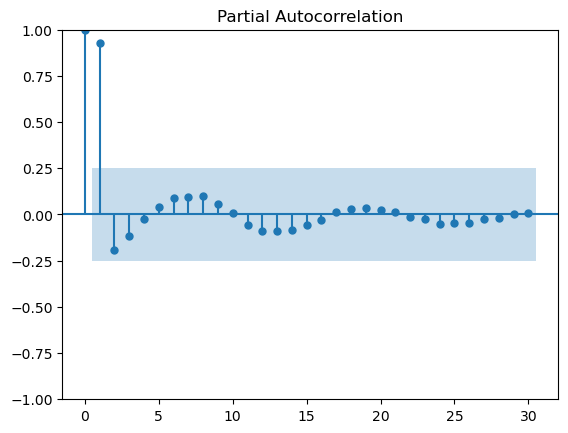

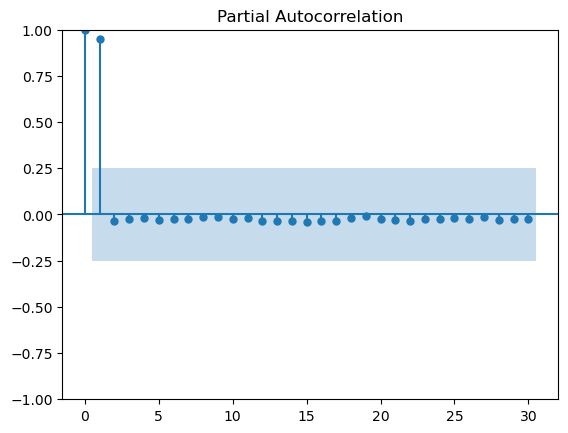

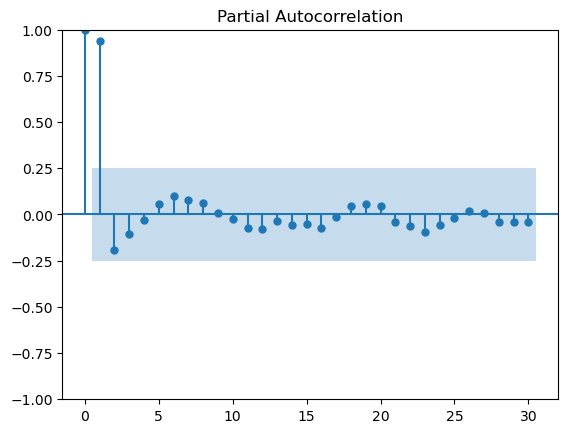

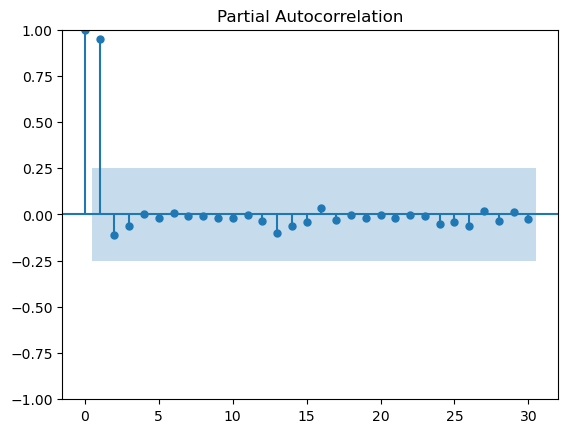

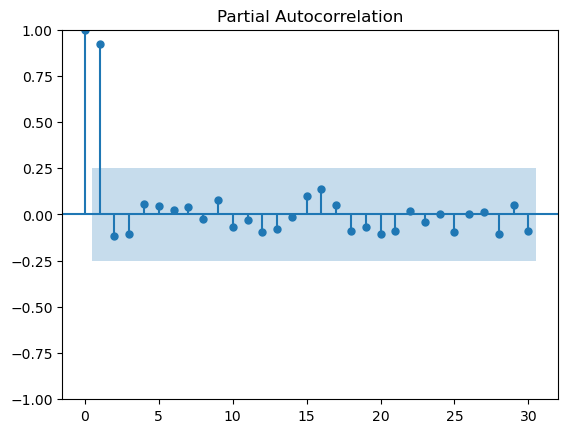

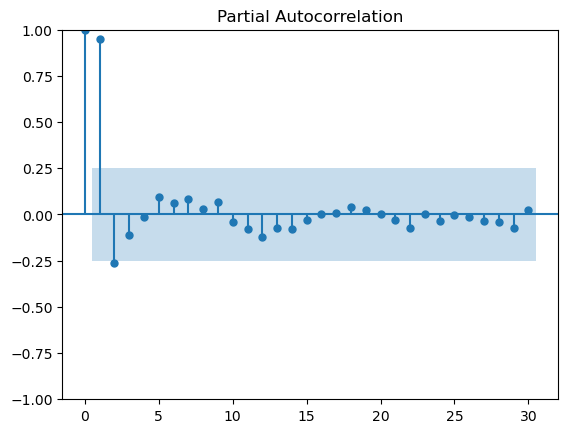

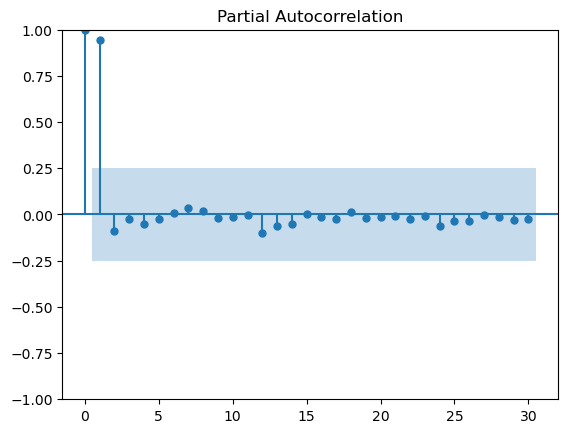

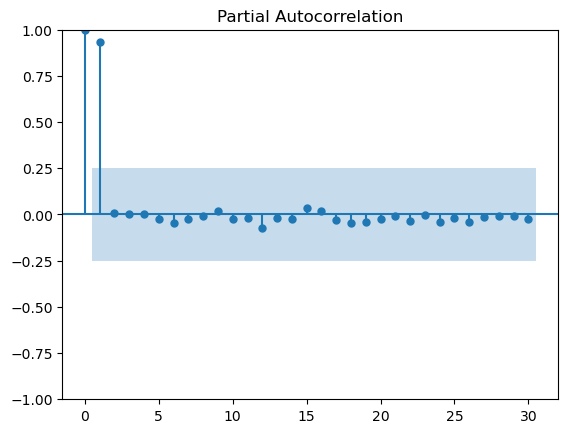

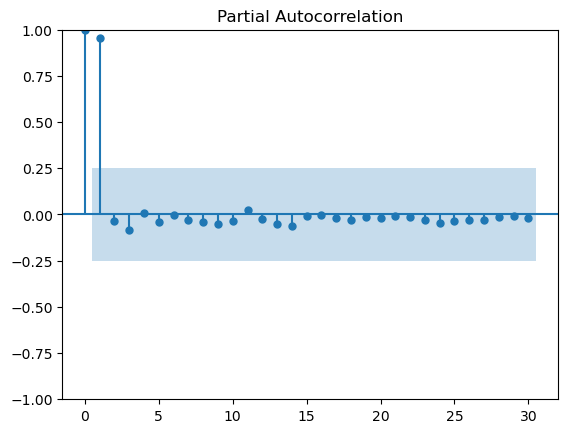

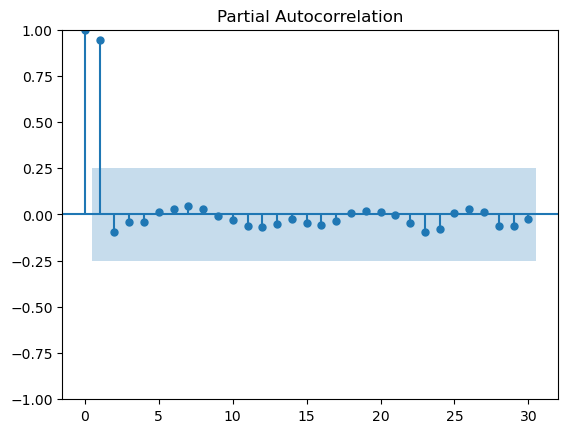

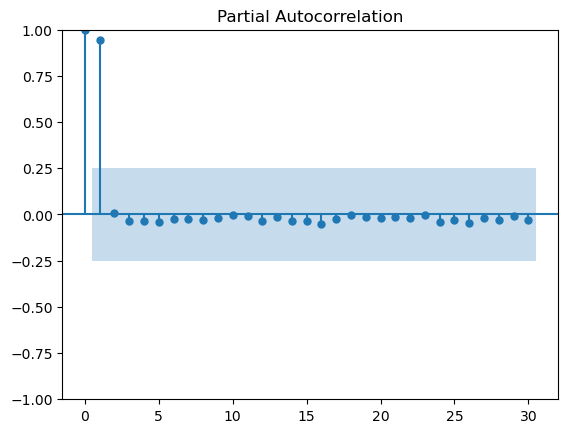

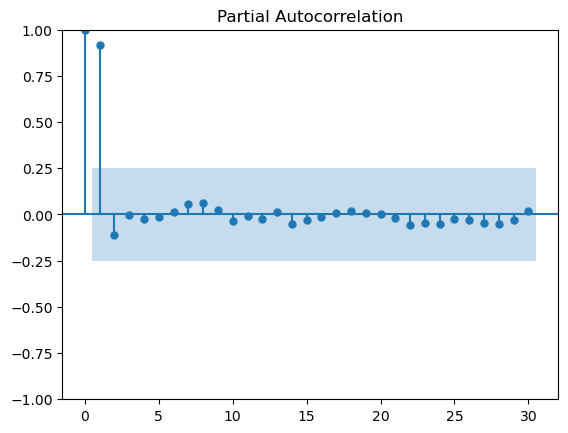

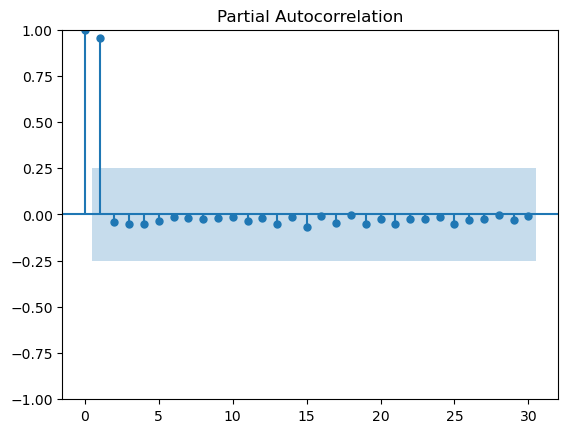

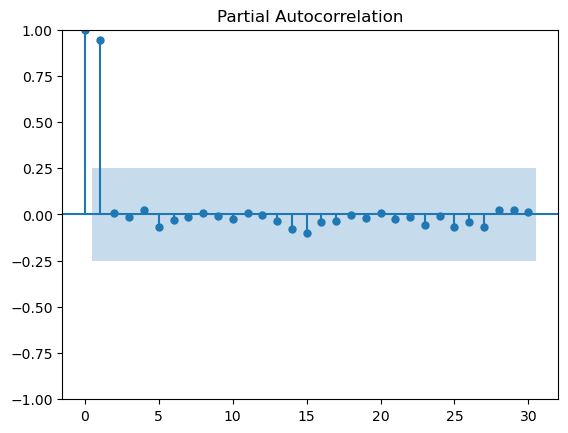

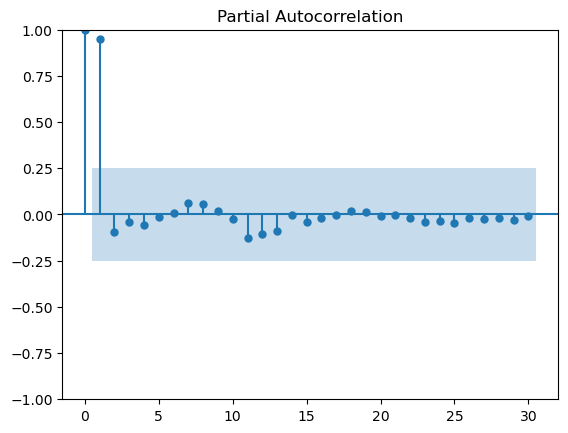

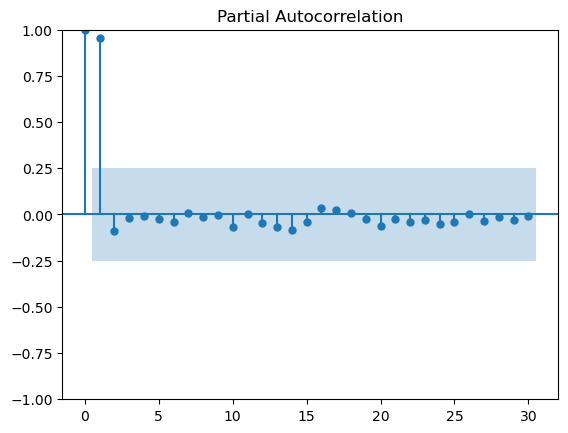

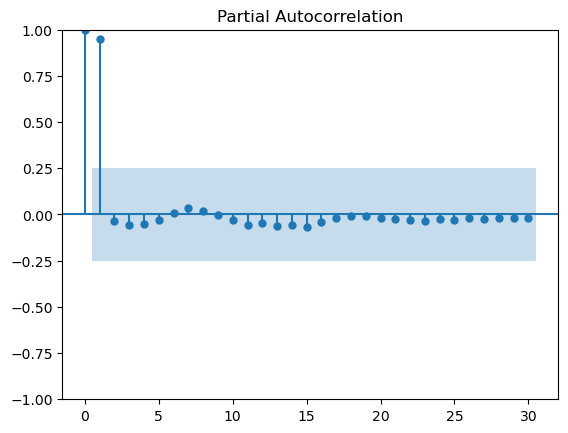

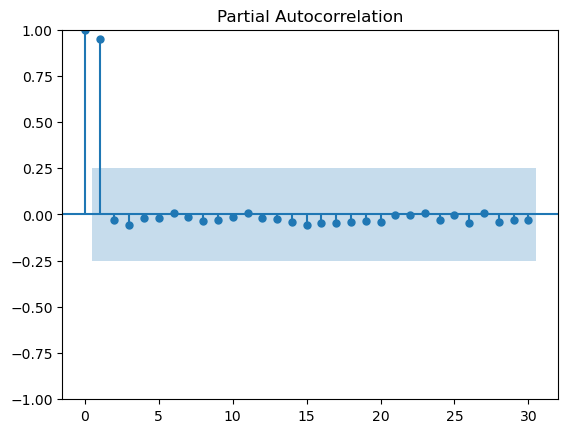

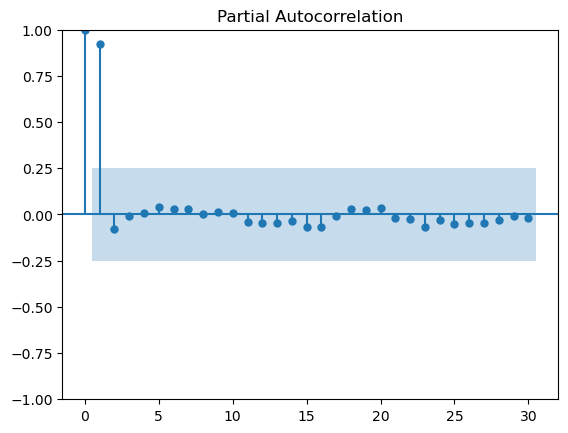

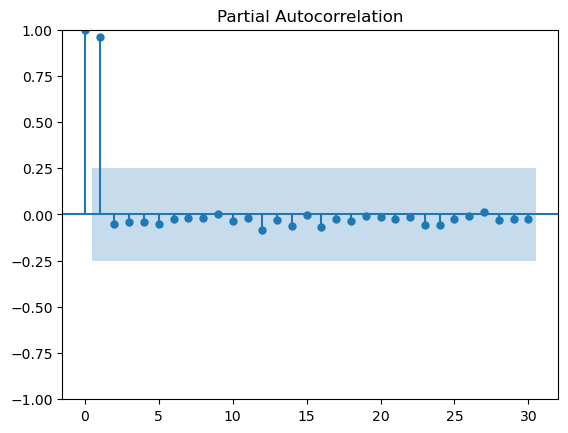

In [16]:
# For all cities, largest significant drop is at q=1.
# Some evidence of 12-month seasonality=.
# Spikes are not significant at seasonal lags.
for city in zillow_reg['RegionName'].unique():
    time_series = get_time_series(city, zillow_reg, '2015-01-31', '2019-12-31')
    plot_pacf(time_series, lags=len(time_series)/2)

#### Define Parameter Sets to Test
- Unadjusted - (0,0,0), non-seasonal
- Adjusted, small - (1, 1, 1), non-seasonal
- Adjusted, medium - (3, 1, 1), non-seasonal
- Adjusted, large - (5, 1, 1), non-seasonal
- Adjusted, small & seasonal - (1, 1, 1), (0, 1, 1, 12)
- Adjusted, medium & seasonal - (3, 1, 1), (0, 1, 1, 12)
- Adjusted, large & seasonal - (5, 1, 1), (0, 1, 1, 12)
- Adjusted, small & seasonal - (1, 1, 1), (1, 1, 1, 12)
- Adjusted, medium & seasonal - (3, 1, 1), (1, 1, 1, 12)
- Adjusted, large & seasonal - (5, 1, 1), (1, 1, 1, 12)

In [18]:
model_specs = [
    ((0, 0, 0), (0, 0, 0 ,0)),
    ((1, 1, 1), (0, 0, 0 ,0)),
    ((3, 1, 1), (0, 0, 0 ,0)),
    ((5, 1, 1), (0, 0, 0 ,0)),
    
    ((1, 1, 1), (0, 1, 1, 12)),
    ((3, 1, 1), (0, 1, 1, 12)),
    ((5, 1, 1), (0, 1, 1, 12)),
    
    ((1, 1, 1), (1, 1, 1, 12)),
    ((3, 1, 1), (1, 1, 1, 12)),
    ((5, 1, 1), (1, 1, 1, 12)),
]

#### Conduct test

In [20]:
scores = {}
warnings.filterwarnings('ignore')
for city in zillow_reg['RegionName'].unique():
    scores[city] = {}
    for spec in model_specs:
        scores[city][str(spec)] = train_and_test_arima(
            arima_params = spec,
            city = city,
            df = zillow_reg,
            train_start_date = '2015-01-01',
            train_end_date = '2016-12-31',
            test_start_date = '2017-01-01',
            test_end_date = '2017-12-31',
            score_func = rmse
        )

In [21]:
for city in zillow_reg['RegionName'].unique():
    city_keys = list(scores[city].keys())
    city_scores = [scores[city][key] for key in city_keys]
    best_model = city_keys[np.argmin(city_scores)]
    best_score = scores[city][best_model]
    print(f"'{city}': {best_model}; Score {best_score}")

'New York, NY': ((1, 1, 1), (0, 1, 1, 12)); Score 12.132630828717303
'Los Angeles, CA': ((3, 1, 1), (0, 1, 1, 12)); Score 10.905937827960825
'Chicago, IL': ((3, 1, 1), (1, 1, 1, 12)); Score 9.496138348457876
'Dallas, TX': ((3, 1, 1), (1, 1, 1, 12)); Score 20.673491430732206
'Houston, TX': ((5, 1, 1), (0, 0, 0, 0)); Score 17.275254491752488
'Washington, DC': ((3, 1, 1), (0, 1, 1, 12)); Score 22.056738643659877
'Philadelphia, PA': ((3, 1, 1), (1, 1, 1, 12)); Score 7.879504092138576
'Miami, FL': ((1, 1, 1), (0, 1, 1, 12)); Score 8.055097818095263
'Atlanta, GA': ((3, 1, 1), (0, 1, 1, 12)); Score 13.148428560364794
'Boston, MA': ((3, 1, 1), (1, 1, 1, 12)); Score 15.942101804661647
'Phoenix, AZ': ((3, 1, 1), (0, 1, 1, 12)); Score 9.525452332419432
'San Francisco, CA': ((5, 1, 1), (1, 1, 1, 12)); Score 57.992540819958755
'Riverside, CA': ((1, 1, 1), (0, 1, 1, 12)); Score 33.30129986029823
'Detroit, MI': ((1, 1, 1), (0, 0, 0, 0)); Score 19.511946572638788
'Seattle, WA': ((3, 1, 1), (1, 1, 1, 1

In [22]:
scores

{'New York, NY': {'((0, 0, 0), (0, 0, 0, 0))': 61.79195524488783,
  '((1, 1, 1), (0, 0, 0, 0))': 97.38569026768923,
  '((3, 1, 1), (0, 0, 0, 0))': 49.366687316176936,
  '((5, 1, 1), (0, 0, 0, 0))': 49.916958868139446,
  '((1, 1, 1), (0, 1, 1, 12))': 12.132630828717303,
  '((3, 1, 1), (0, 1, 1, 12))': 14.294993061911146,
  '((5, 1, 1), (0, 1, 1, 12))': 20.524764235563683,
  '((1, 1, 1), (1, 1, 1, 12))': 12.132630828717303,
  '((3, 1, 1), (1, 1, 1, 12))': 14.29499306191221,
  '((5, 1, 1), (1, 1, 1, 12))': 20.524764239882476},
 'Los Angeles, CA': {'((0, 0, 0), (0, 0, 0, 0))': 190.7337272838622,
  '((1, 1, 1), (0, 0, 0, 0))': 27.172404659735637,
  '((3, 1, 1), (0, 0, 0, 0))': 24.399821001127187,
  '((5, 1, 1), (0, 0, 0, 0))': 23.946551586981343,
  '((1, 1, 1), (0, 1, 1, 12))': 10.957582464479367,
  '((3, 1, 1), (0, 1, 1, 12))': 10.905937827960825,
  '((5, 1, 1), (0, 1, 1, 12))': 16.63688496153981,
  '((1, 1, 1), (1, 1, 1, 12))': 10.957582464479367,
  '((3, 1, 1), (1, 1, 1, 12))': 10.905937

In [23]:
with open('..\\data\\arima_tuning\\pre_merger_arima_scores.json', 'w') as outfile:
    json.dump(scores, outfile)

In [24]:
scores = {}
warnings.filterwarnings('ignore')
for city in zillow_reg['RegionName'].unique():
    scores[city] = {}
    for spec in model_specs:
        scores[city][str(spec)] = train_and_test_arima(
            arima_params = spec,
            city = city,
            df = zillow_reg,
            train_start_date = '2017-12-01',
            train_end_date = '2018-12-31',
            test_start_date = '2019-01-01',
            test_end_date = '2020-01-01',
            score_func = rmse
        )

In [25]:
for city in zillow_reg['RegionName'].unique():
    city_keys = list(scores[city].keys())
    city_scores = [scores[city][key] for key in city_keys]
    best_model = city_keys[np.argmin(city_scores)]
    best_score = scores[city][best_model]
    print(f"'{city}': {best_model}; Score {best_score}")

'New York, NY': ((1, 1, 1), (0, 1, 1, 12)); Score 12.222519345811321
'Los Angeles, CA': ((3, 1, 1), (1, 1, 1, 12)); Score 14.53945931331705
'Chicago, IL': ((1, 1, 1), (0, 1, 1, 12)); Score 7.74517450065115
'Dallas, TX': ((1, 1, 1), (0, 1, 1, 12)); Score 6.711693210581466
'Houston, TX': ((1, 1, 1), (0, 1, 1, 12)); Score 6.802811230710027
'Washington, DC': ((1, 1, 1), (0, 1, 1, 12)); Score 19.07428288398978
'Philadelphia, PA': ((1, 1, 1), (0, 1, 1, 12)); Score 6.976670458336831
'Miami, FL': ((1, 1, 1), (0, 1, 1, 12)); Score 8.75370068618821
'Atlanta, GA': ((1, 1, 1), (0, 1, 1, 12)); Score 23.040240747717
'Boston, MA': ((1, 1, 1), (0, 1, 1, 12)); Score 7.89884156734191
'Phoenix, AZ': ((3, 1, 1), (1, 1, 1, 12)); Score 5.545277781188455
'San Francisco, CA': ((1, 1, 1), (0, 1, 1, 12)); Score 22.188889471579426
'Riverside, CA': ((1, 1, 1), (0, 1, 1, 12)); Score 17.387505057462462
'Detroit, MI': ((1, 1, 1), (0, 1, 1, 12)); Score 31.249903623664057
'Seattle, WA': ((1, 1, 1), (0, 1, 1, 12)); Sco

In [26]:
# With only a 1-year train period and a 1-yr forecast period, all models with seasonality appear equally good.
# Preferring ((3, 1, 1), (0, 1, 1, 12)) for best balance of model simplicity, consistency, accuracy and fit with diagnostics.
scores

{'New York, NY': {'((0, 0, 0), (0, 0, 0, 0))': 84.16095655893197,
  '((1, 1, 1), (0, 0, 0, 0))': 126.72380033477066,
  '((3, 1, 1), (0, 0, 0, 0))': 86.03849251491033,
  '((5, 1, 1), (0, 0, 0, 0))': 94.46968469319043,
  '((1, 1, 1), (0, 1, 1, 12))': 12.222519345811321,
  '((3, 1, 1), (0, 1, 1, 12))': 12.222519345811321,
  '((5, 1, 1), (0, 1, 1, 12))': 12.222519345811321,
  '((1, 1, 1), (1, 1, 1, 12))': 12.222519345811321,
  '((3, 1, 1), (1, 1, 1, 12))': 12.222519345811321,
  '((5, 1, 1), (1, 1, 1, 12))': 12.222519345811321},
 'Los Angeles, CA': {'((0, 0, 0), (0, 0, 0, 0))': 83.90849740840166,
  '((1, 1, 1), (0, 0, 0, 0))': 44.75032282394043,
  '((3, 1, 1), (0, 0, 0, 0))': 49.731055157826695,
  '((5, 1, 1), (0, 0, 0, 0))': 18.687404514124125,
  '((1, 1, 1), (0, 1, 1, 12))': 14.53945931331743,
  '((3, 1, 1), (0, 1, 1, 12))': 14.53945931331743,
  '((5, 1, 1), (0, 1, 1, 12))': 14.53945931331743,
  '((1, 1, 1), (1, 1, 1, 12))': 14.53945931331743,
  '((3, 1, 1), (1, 1, 1, 12))': 14.5394593133

In [27]:
with open('..\\data\\arima_tuning\\post_merger_arima_scores.json', 'w') as outfile:
    json.dump(scores, outfile)